In [1]:
import preprocess
import featureprocess
import fileio
import evaluation
import numpy as np
import modelacc
import pandas as pd
from sklearn.impute import SimpleImputer

In [2]:
dfoff,dftest,dfon = fileio.read_all()
dfoff,dfall,train,valid = preprocess.preprocess(dfoff)

In [5]:
dfoff = featureprocess.process_features_main(dfoff)
dfall = featureprocess.process_features_main(dfall)

train = featureprocess.process_features_main(train)
valid = featureprocess.process_features_main(valid)
dftest = featureprocess.process_features_main(dftest)

In [8]:
def get_lastfeatures(manjian=True,weekdays=True,distance = True,people=True):
    
    
    lastfeatures = []
    weekdaycols = ['weekday_' + str(i) for i in range(1,8)]

    if manjian:
        lastfeatures = lastfeatures+ ['discount_rate','discount_type','discount_man', 'discount_jian']
    if weekdays:
        lastfeatures = lastfeatures+['weekday', 'weekday_type'] #+ weekdaycols
    if distance:
        lastfeatures = lastfeatures+['Distance']
    if people:
        #lastfeatures = lastfeatures+['只领券', '核销数', '直接买', '单商铺最大购买次数', '成交商家数']
        lastfeatures = lastfeatures+['核销数']
    
    if not len(lastfeatures):
        print('None features')
        return
    
    return lastfeatures



# 特征测试

In [4]:
#x_train,y_train,x_test,y_test = preprocess.split_xy(train,valid,columns=get_lastfeatures())
#
#model_name,model_score = modelacc.hodgepodge(modelacc.classifiers,x_train,y_train,x_test,y_test,valid)
#np.mean(model_score)

In [5]:
combine_list = []
def combine(a=None,b=None,combine_list=combine_list):
    
    if a == None:
        a,b = '0','1'
    
    c,d = '0','1'
    
    a1 = a+c
    a2 = a+d
    a3 = b+c
    a4 = b+d
    
    if len(a1) == 4:
        combine_list = combine_list+[a1,a2,a3,a4]
        return combine_list
    
    else:
        combine_list = combine(a1,a2,combine_list)
        combine_list = combine(a3,a4,combine_list)

    return combine_list
    
ll = combine()
combine_list = []
for i in ll:
    combine_list.append([True   if l == '0' else False for l in i  ])
        

In [6]:
feature_list = ['manjian','weekdays','distance','people']

dfobj = pd.DataFrame(columns = ['均值','最小','最大','标准差'],index = ll)

for l01 in ll:
    i = [True   if l == '1' else False for l in l01  ]
    if not True in i:
        continue
        
    x_train,y_train,x_test,y_test = preprocess.split_xy(train,valid,columns=get_lastfeatures(manjian=i[0],
                                                                                         weekdays=i[1],distance = i[2],people=i[3]))
    model_name,model_score = modelacc.hodgepodge(modelacc.classifiers,x_train,y_train,x_test,y_test,valid)
    
    print([feature_list[leng] for leng in range(0,len(i)) if i[leng] is True ])
    dfobj.loc[l01,:] = [np.mean(model_score),np.max(model_score),np.min(model_score),np.std(model_score)]

Logistic Regression 0.5425822261788051 	
Decision Tree 0.547515458865813 	
Random Forest 0.5452302574127559 	
AdaBoost 0.5467100670013958 	
Extra Trees 0.5475891342856105 	
GradientBoosting 0.549399612017644 	
Bagging 0.5475470364803825 	
Naive Bayes 0.5431649952862895 	
LDA 0.5437626455132502 	
MLP 0.5471313875095236 	
XGB 0.5472108694401866 	
['people']
Logistic Regression 0.5509217343920725 	
Decision Tree 0.5474590751420415 	
Random Forest 0.547391489761952 	
AdaBoost 0.5490947353076935 	
Extra Trees 0.547342308099308 	
GradientBoosting 0.547342308099308 	
Bagging 0.547342308099308 	
Naive Bayes 0.5509217343920725 	
LDA 0.5509217343920725 	
MLP 0.5509217343920725 	
XGB 0.547342308099308 	
['distance']
Logistic Regression 0.5732154391414557 	
Decision Tree 0.5475775335697141 	
Random Forest 0.5731615749420736 	
AdaBoost 0.5709727649224808 	
Extra Trees 0.5476966576410341 	
GradientBoosting 0.5233815730444801 	
Bagging 0.5476171838418007 	
Naive Bayes 0.5771750285061441 	
LDA 0.57390

In [8]:
dfobj.sort_values('均值')

,均值,最小,最大,标准差
1000,0.5,0.5,0.5,0
1100,0.504189,0.518716,0.49593,0.00585493
0100,0.510131,0.518755,0.509217,0.00273126
1110,0.545965,0.555137,0.537965,0.00554577
1001,0.546099,0.548622,0.542352,0.00215775
0001,0.546168,0.5494,0.542582,0.00206773
1101,0.546489,0.553434,0.541188,0.0039441
1010,0.548588,0.550922,0.543133,0.00227812
0010,0.548818,0.550922,0.547342,0.00166164
0101,0.548947,0.55936,0.542068,0.00446313


In [44]:
# UM特征的单测试
x_train,y_train,x_test,y_test = preprocess.split_xy(train,valid,columns=get_lastfeatures(manjian=0,
                                                                                     weekdays=0,distance = 1,people=1))
model_name,model_score = modelacc.hodgepodge(modelacc.classifiers,x_train,y_train,x_test,y_test,valid)

#print([feature_list[leng] for leng in range(0,len(i)) if i[leng] is True ])
#dfobj.loc[l01,:] = [np.mean(model_score),np.max(model_score),np.min(model_score),np.std(model_score)]

In [10]:
dftest.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'discount_rate', 'discount_man', 'discount_jian',
       'discount_type', 'weekday', 'weekday_type', 'weekday_1', 'weekday_2',
       'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weekday_7',
       'UM_id', '用户id', '只领券', '核销数', '直接买', '单商铺最大购买次数', '成交商家数'],
      dtype='object')

# 提交

In [58]:
def output_submit(model_this,original_feature):
    final_model = model_this
    y_test_pred = model_this.predict_proba(dftest[original_feature])
    dftest1 = dftest[['User_id','Coupon_id','Date_received']].copy()
    dftest1['label'] = y_test_pred[:,1]
    #dftest1.to_csv(name, index=False, header=False)
    return dftest1

def count_fenshu(model,x_train,y_train,x_test,y_test,valid):
    model.fit(x_train, y_train)
    y_pre = model.predict(x_test)
    y_prob = model.predict_proba(x_test)
    cc = evaluation.get_official_auc(y_prob[:,1],y_test,valid)
    return cc,model

In [46]:
model_lr = modelacc.classifiers[0][1]
model_nbays = modelacc.classifiers[7][1]
model_lda = modelacc.classifiers[8][1]
model_mlp = modelacc.classifiers[9][1]

In [47]:
model_name = ['lr','bays','lda','mlp']
model_list = [model_lr,model_nbays,model_lda,model_mlp]

In [48]:
model_score = []
model_fited = []
for model in model_list:
    score_,model_ = count_fenshu(model,x_train,y_train,x_test,y_test,valid)
    model_score.append(score_)
    model_fited.append(model_)
    

In [60]:
dfsub_list = []
for model in model_fited:
    dfsub_list.append(output_submit(model,x_train.columns))

In [128]:
def toupiao(dfsub_list):
    label_list = []
    for i in dfsub_list:
        label_list.append(i.label)
    dftp = pd.DataFrame(label_list).T    
    dftp.loc[:,'max'] = dftp.max(axis=1) 
    dftp.loc[:,'min'] = dftp.min(axis=1) 
    dftp.loc[:,'mean'] = dftp.mean(axis=1) 
    
    dfdiji = dfsub_list[0].loc[:,['User_id','Coupon_id', 'Date_received']]
    dftest_max = pd.concat([dfdiji,dftp.loc[:,'max']],axis=1) 
    dftest_min = pd.concat([dfdiji,dftp.loc[:,'min']],axis=1) 
    dftest_mean = pd.concat([dfdiji,dftp.loc[:,'mean']],axis=1)
    return dftest_max,dftest_min,dftest_mean

In [129]:
dftest_max,dftest_min,dftest_mean = toupiao(dfsub_list)

In [135]:
for i in zip([dftest_max,dftest_min,dftest_mean],['max','min','mean']):
    i[0].to_csv('../storage/20201021'+i[1]+'.csv', index=False, header=False)

In [11]:
# 
model_lr = modelacc.classifiers[0][1]

#original_feature = ['discount_rate','discount_type','discount_man', 'discount_jian','Distance', 'weekday', 'weekday_type'] + weekdaycols
original_feature = x_train.columns
final_model = model_lr
y_test_pred = final_model.predict_proba(dftest[original_feature])
dftest1 = dftest[['User_id','Coupon_id','Date_received']].copy()
dftest1['label'] = y_test_pred[:,1]
dftest1.to_csv('submit_xgb.csv', index=False, header=False)
dftest1.head()

In [17]:
import matplotlib.pyplot as plt

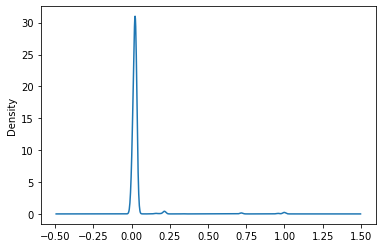

In [22]:
dftest1.label.plot(kind = 'kde')

In [25]:
dftest1.label

0         0.024014
1         0.020143
2         0.011846
3         0.011846
4         0.020143
            ...   
113635    0.004856
113636    0.020143
113637    0.020143
113638    0.028608
113639    0.011846
Name: label, Length: 113640, dtype: float64